In [2]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
from tensorflow import keras
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
from google.colab import drive
import os
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image as Img
from keras.models import Model, load_model
from keras.layers import Input
import tensorflow as tf
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=True
)
# We'll extract features at the final pool layer.
model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('avg_pool').output
)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
os.chdir('/content/drive/MyDrive/videos')
os.getcwd().split('/')[-1]
label_list=os.listdir()
Xtrain=np.zeros((1,40,2048))
Ytrain=np.zeros((1,4))
Xtest=np.zeros((1,40,2048))
Ytest=np.zeros((1,4))
for direc in label_list:
    os.chdir('/content/drive/MyDrive/videos')
    os.chdir(os.getcwd()+'/' +direc)
    y_label=np.zeros((1,4))
    for j in range(0,len(label_list)):
        if(label_list[j]==direc):
            y_label[0][j]=1
    k=1
    for vid in os.listdir():
        print(vid)
        sequence=[]
        cap = cv2.VideoCapture(os.getcwd()+'/' +vid)       
        success=1
        count=0
        while success: 
            success, image = cap.read() 
            if success:
                x = Img.img_to_array(image)
                x = np.expand_dims(x, axis=0)   
                features=model.predict(x)
                sequence.append(features[0])
                count += 1
        scaled_sequence=[]
        skip=len(sequence)//40
        num=0
        for i in range(1,len(sequence),skip):
            scaled_sequence.append(sequence[i])
            num+=1
            if(num==40):
                break
        each_row=np.array(scaled_sequence)
        each_row=np.expand_dims(each_row,axis=0)
        # print(each_row.shape)
        
        if(k%5!=0):
            Xtrain=np.vstack((Xtrain,each_row))
            Ytrain=np.vstack((Ytrain,y_label))
        else:
            Xtest=np.vstack((Xtest,each_row))
            Ytest=np.vstack((Ytest,y_label))
        k+=1
    # print(direc)
    # os.chdir('/content/drive/MyDrive/videos')


In [3]:
Xtrain=np.load('/content/drive/MyDrive/x_train_data_25_2.npy')
Ytrain=np.load('/content/drive/MyDrive/y_train_data_25_2.npy')
Xtest=np.load('/content/drive/MyDrive/x_test_data_25_2.npy')
Ytest=np.load('/content/drive/MyDrive/y_test_data_25_2.npy')

In [5]:
mode.load_weights('../weights/vgg_adam_noreg.hdf5')
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,Add,Activation
import random
mod=tf.keras.models.Sequential()
mod.add(LSTM(2048, return_sequences=False,input_shape=(40,2048),dropout=0.5))
# mod.add(LSTM(512, return_sequences=False,input_shape=(40,2048),dropout=0.5))
# mod.add(Dense(512, activation='relu'))
mod.add(Dense(512, activation='relu'))
mod.add(Dense(30, activation='softmax'))
mod.summary()
mod.load_weights('../weights/Project.hdf5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2048)              33562624  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 30)                15390     
Total params: 34,627,102
Trainable params: 34,627,102
Non-trainable params: 0
_________________________________________________________________


In [6]:
def shuffle(X,Y):
    n=X.shape[0]
    X_new=np.zeros((X.shape[0],X.shape[1],X.shape[2]))
    Y_new=np.zeros((Y.shape[0],Y.shape[1]))
    li=[i for i in range(1,n)]
    random.shuffle(li)
    k=0
    for j in li:
      X_new[k]=X[j]
      Y_new[k]=Y[j]
      k+=1

    return X_new,Y_new

In [7]:
X_new,Y_new=shuffle(Xtrain,Ytrain)

In [8]:
Y_new.shape

(2652, 30)

In [ ]:
optimizer = Adam(lr=1e-5, decay=1e-6)
topk=tf.keras.metrics.TopKCategoricalAccuracy(
    k=2, name='top_k_categorical_accuracy', dtype=None
)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Project.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
mod.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy',topk])
output=mod.fit(X_new,Y_new,epochs=200,validation_data=(Xtest,Ytest),batch_size=50,callbacks = [model_checkpoint_callback])

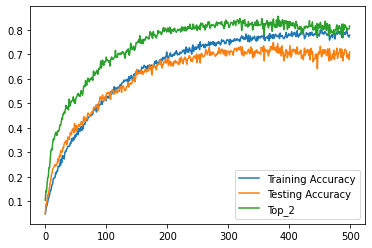

In [12]:
plt.plot(output.history['accuracy'])
plt.plot(output.history['val_accuracy'])
plt.plot(output.history['val_top_k_categorical_accuracy'])
plt.legend(['Training Accuracy','Testing Accuracy','Top_2'])

In [13]:
y_true = Ytest.argmax(-1)
y_pred = mod.predict(Xtest).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
A = confusion_matrix(y_true, y_pred)

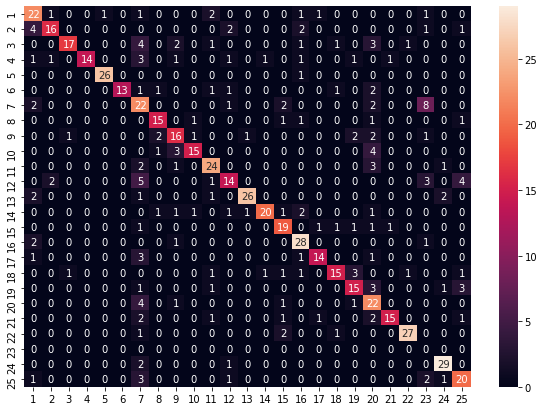

In [17]:
df_cm = pd.DataFrame(A, index = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]],
                  columns = [i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])
plt.figure(figsize = (10,7))
import seaborn as sns
sns.heatmap(df_cm, annot=True)

Experiments:

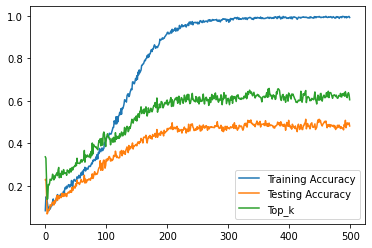

In [ ]:

plt.plot(cnnoutput.history['accuracy'])
plt.plot(cnnoutput.history['val_accuracy'])
plt.plot(cnnoutput.history['val_top_k_categorical_accuracy'])
plt.legend(['Training Accuracy','Testing Accuracy','Top_k'])